## <center> Q-Learning - Continuous Actions</center>


In [1]:
import time 
import gym
import numpy as np 
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Part 1: 

Environment Setup - Cart Pole

Let us take a look at the possible actions.
You can find them here: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
As we can see, there are 4 observations:
* Cart Position (-4.8 to 4.8)
* Cart Velocity $(-\infty \text{ to } \infty)$
* Pole Angle (-0.418 to 0.418) rad or (-24 to 24) degrees
* Pole Angular Velocity $(-\infty \text{ to } \infty)$

and two actions:
* 0 - Move to the left
* 1 - Move to the right

In [2]:
env = gym.make("CartPole-v1")  # We want to solve the CartPole task
env.reset()  # Reset to initial state
for _ in range(100):
    clear_output(wait=True) # Clears the previous output
    env.render(mode="human")  # Render on the screen

    action = env.action_space.sample()  # chose a random action
    observation, reward, done, *info = env.step(action)  # Perform random action on the environment

    cart_p, cart_v, pole_a, pole_v = observation

    print(f"""    Cart Position: {cart_p}
    Cart Velocity: {cart_v}
    Pole Angle: {pole_a}
    Pole Velocity: {pole_v}
    Reward: {reward}
    Done: {done}""")

    time.sleep(0.1)

    if done:
        break

env.close()  # dont forget to close the environment

    Cart Position: -0.2645484447177071
    Cart Velocity: -1.0143407691948612
    Pole Angle: 0.22114651430371637
    Pole Velocity: 1.5530022132565968
    Reward: 1.0
    Done: True


### Part 2:
Discretization for Q Table

We need to solve one problem before we can start working on the implementation:
The Q-Learning algorithm relies on the creation of discrete Q-Tables but our environment returns continuous values (angle and velocity).
So we need to discretize our observation, i.e we assign each observation to a discrete state.
To do so, we need to define a number of classes for each observation in order to assign each observation to one of those classes.<br />
In fact those classes are called *bins*

Let us just say that we want to allow 10 possible observations, thus each continuous observation is put into one of the 10 bins. For the sake of convenience, we dont use the range $-\infty$ to $\infty$ for the velocity, but -5 to 5.


In [3]:
NUM_BINS = 10

bins_cart_p = np.linspace(-4.8, 4.8, NUM_BINS)  # bins for the cart position
bins_cart_v = np.linspace(-5, 5, NUM_BINS)  # bins for the cart velocity
bins_pole_a = np.linspace(-0.418, 0.418, NUM_BINS)  # bins for the pole angle
bins_pole_v = np.linspace(-5, 5, NUM_BINS)  # bins for the pole angular velocity

BINS = np.array([bins_cart_p, bins_cart_v, bins_pole_a, bins_pole_v])  # merge them


print(f"Bins for Cart Position: {BINS[0]}")
print(f"Bins for Cart Velocity: {BINS[1]}")
print(f"Bins for Pole Angle: {BINS[2]}")
print(f"Bins for Pole Angular Velocity : {BINS[3]}")

Bins for Cart Position: [-4.8        -3.73333333 -2.66666667 -1.6        -0.53333333  0.53333333
  1.6         2.66666667  3.73333333  4.8       ]
Bins for Cart Velocity: [-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]
Bins for Pole Angle: [-0.418      -0.32511111 -0.23222222 -0.13933333 -0.04644444  0.04644444
  0.13933333  0.23222222  0.32511111  0.418     ]
Bins for Pole Angular Velocity : [-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]


#### Mapping from Continuous to Discrete

We now need to write a function which maps each observation to one of those values. Luckily numpy provides the function *digitize(data, bins)* for us which takes care of the mapping. 

*np.digitize()* returns the index of the bin which is closest to the data to be mapped

In [4]:
### Digitize Demo ###
demo_bin = [0, 1, 2, 3, 4, 5]

# How bins are read:
# Bin 0: (-inf, 0) --> output 0

# Bin 1: [0, 1) --> output 1
# Bin 2: [1, 2) --> output 2
# Bin 3: [2, 3) --> output 3
# Bin 4: [3, 4) --> output 4
# Bin 5: [4, 5) --> output 5

# Bin 6: [5, inf) --> output 6

demo_data = [-0.1, 0.1, 1.1, 2.1, 3.1, 4.1, 5.1]
for val in demo_data:
    print(np.digitize(val, demo_bin))

0
1
2
3
4
5
6


Knowing how np.digitize works, the data can be discretized

In [5]:
def binner(observations, bins):
    binned_observations = []

    for ind, observation in enumerate(observations):
        binned_val = np.digitize(observation, bins[ind])
        binned_observations.append(binned_val)
    
    return tuple(binned_observations) # Important for later indexing

Let us test our function

In [6]:
env = gym.make("CartPole-v1") 
observation = env.reset()  # Remember that env.reset() returns the intial observation

print(f"Cart Position: {observation[0]}")
print(f"Cart Velocity: {observation[1]}")
print(f"Pole Angle: {observation[2]}")
print(f"Pole Angular Velocity : {observation[3]}")

env.close()

Cart Position: 0.013129249205329624
Cart Velocity: -0.04750246653725707
Pole Angle: 0.02126865960273175
Pole Angular Velocity : 0.02341352230715213


In [7]:
mapped_observation = binner(observation, BINS)
print(mapped_observation)

(5, 5, 5, 5)


(5, 5, 5, 5) means that each observation is assigned to bin 5.
Lets check if that is correct

Bin 5 contains the values 0.53333/0.55555 for all observations which leads to bin 5 for each individual observation! <br />
But another test might be a good idea.
Lets define the array: <br />
test = (-5, 5, 0.2, -4). <br />
If our function works correctly, it should output:(0, 10, 7, 1) as those are the bins corresponding to those values

In [8]:
test = (-5, 5, 0.2, -4)
binner(test, BINS)  # Nice!

(0, 10, 7, 1)

Now that we validated the functionality of our function it is time to move on with the Q-Learning algorithm. <br />
Let us create the Q-Table:
Remember that the Q-Table has a cell for each permutation of state-action pair. <br />
As there are 4 possible observations, (with 10 bins each) and 2 actions this yields that:
$10*10*10*10*2$ cells are needed to cover all permutations

We can create the Q-Table by using np.zeros(shape)

In [9]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(10, 10, 10, 10, 2)


### Part 3
Constants and Hyperparameters

In [10]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9

In [11]:
# Exploration vs. Exploitation parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001             # Exponential decay rate for exploration prob

### Part 4
Now it is time to dive into the training / Q-Table update methodology.

In [12]:
def action_selection(epsilon, q_table, discrete_state):
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        action = np.argmax(q_table[discrete_state])

    # EXPLORATION, USE A RANDOM ACTION
    else:
        action = np.random.randint(0, env.action_space.n)

    return action

In [13]:
def q_update(old_q_value, reward, next_optimal_q_value):
    new_q = (1-ALPHA)*old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value)
    return new_q

In [14]:
BURN_IN = 100
epsilon = 1

EPSILON_END= 15000
EPSILON_REDUCE = 0.0001

# Note, this is an alternative to our previous exponential decay, its a linear decay. It's not worse or better, 
# just an alternative.


def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        # The epsilon starts to decrease right from the start, and once the EPSILON_END is reached, 
        # the epsilon value remains constant.
        epsilon -= EPSILON_REDUCE
    
    return epsilon

In [15]:
def fail(done, points, reward):
    if done and points < 150:
        # In this case, the agent gets a big penalization if does the job in many steps.
        reward = -200

    return reward

#### Training

In [16]:
# Lists
points_vec = []  # to store all achieved points
mean_points = []  # to store a running mean of the last 30 results


# Play 20k games
for episode in range(EPOCHS):

    # Reset the environment
    env = gym.make("CartPole-v1") 
    state = env.reset()
    binned_state = binner(state, BINS)
    
    done = False  # to stop current run when cartpole falls down   
    points = 0  # store result 


    while not done:
        action = action_selection(epsilon, q_table, binned_state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        next_state, reward, done, *info = env.step(action)
        reward = fail(done, points, reward)  # Check if reward or fail state

        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[binned_state + (action,)]  # get the old Q-Value from the Q-Table
        # In this case the notation binned_state + (action,) appends to the tuple binned_state the action to have a new tuple

        # Get the next optimal Q-Value
        binned_next_state = binner(next_state, BINS) # map the next observation to the bins
        next_optimal_q_value = np.max(q_table[binned_next_state])  

        # Update q value
        q_updated = q_update(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[binned_state + (action,)] = q_updated
        
        # Our new state is state
        binned_state = binned_next_state
        points += 1

    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode)


    points_vec.append(points)  # log overall achieved points for the current epoch
    running_mean = round(np.mean(points_vec[-30:]), 2)  # Compute running mean points over the last 30 epochs
    mean_points.append(running_mean)  # and log it


env.close()

#### Visualization

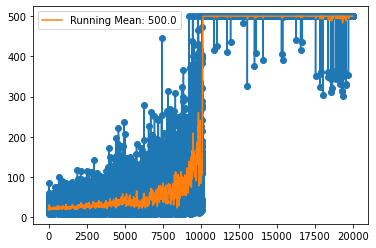

In [17]:
fig, ax = plt.subplots()
ax.scatter(np.arange(0, EPOCHS, 1), points_vec)
ax.plot(np.arange(0, EPOCHS, 1), points_vec)
ax.plot(np.arange(0, EPOCHS, 1), mean_points, label=f"Running Mean: {running_mean}")
plt.legend()

### Part 6.
Now it is time for a final evaluation round! Let's see how well our first RL agent performs

In [19]:
env = gym.make("CartPole-v1") 
observation = env.reset()
rewards = 0

for _ in range(1000):
    env.render(mode="human")
    discrete_state = binner(observation, BINS)  # get bins
    action = np.argmax(q_table[discrete_state])  # and chose action from the Q-Table
    observation, reward, done, *info = env.step(action) # Finally perform the action
    rewards+=1
    if done:
        print(f"You got {rewards} points!")
        break


env.close()

You got 500 points!
